# Demo Regression

In this notebook, we will look showcase how to implement a JAX trainer for research purposes. We will use the documentation from the [uvadlc notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html) and adapt this to the libraries I would like to use:
* serket
* optax

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

ModuleNotFoundError: No module named 'numpy'

In [4]:
# Standard libraries
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict

# JAX/Flax
# If you run this code on Colab, remember to install flax and optax
# !pip install --quiet --upgrade flax optax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
# from flax.training import train_state, checkpoints
import optax

# PyTorch for data loading
import torch
import torch.utils.data as data

# Logging with Tensorboard or Weights and Biases
# If you run this code on Colab, remember to install pytorch_lightning
# !pip install --quiet --upgrade pytorch_lightning
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_23200/3835948096.py:35: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## Data

In [5]:
def target_function(x):
    return np.sin(x * 3.0)

class RegressionDataset(data.Dataset):

    def __init__(self, num_points, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.x = rng.uniform(low=-2.0, high=2.0, size=num_points)
        self.y = target_function(self.x)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

In [6]:
train_set = RegressionDataset(num_points=1000, seed=42)
val_set = RegressionDataset(num_points=200, seed=43)
test_set = RegressionDataset(num_points=500, seed=44)

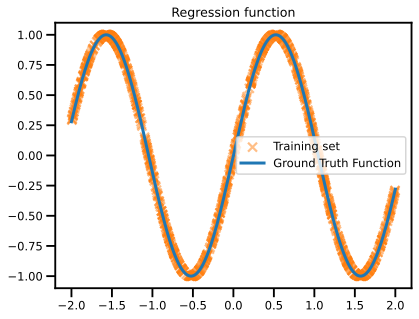

In [7]:

x = np.linspace(-2, 2, 1000)
plt.scatter(train_set.x, train_set.y, color='C1', marker='x', alpha=0.5, label='Training set')
plt.plot(x, target_function(x), linewidth=3.0, label='Ground Truth Function')
plt.legend()
plt.title('Regression function')
plt.show()

## DataLoader

In [8]:
from mylib._src.datamodules.base import NumpyLoader, numpy_collate

In [9]:
def create_data_loaders(*datasets: Sequence[data.Dataset],
                        train: Union[bool, Sequence[bool]]=True,
                        batch_size: int = 128,
                        num_workers: int = 4,
                        seed : int = 42):
    loaders = []
    if not isinstance(train, (list, tuple)):
        train = [train for _ in datasets]
    for dataset, is_train in zip(datasets, train):
        loader = data.DataLoader(dataset,
                                 batch_size=batch_size,
                                 shuffle=is_train,
                                 collate_fn=numpy_collate,
                                 num_workers=num_workers,
                                 persistent_workers=is_train if num_workers > 0 else False,
                                 generator=torch.Generator().manual_seed(seed))
        loaders.append(loader)

    return loaders

In [10]:
batch_size = 64
num_workers = 0

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=batch_size,
                                                            num_workers=num_workers
                                                            )


In [11]:
for ibatch in tqdm(train_loader):
    continue

  0%|          | 0/16 [00:00<?, ?it/s]

In [12]:
ibatch[0].shape, ibatch[1].shape

((40, 1), (40, 1))

## Model

In [13]:
import serket as sk

hidden_dims = [128, 128]
output_dim = 1

model = sk.nn.Sequential(
    [
        sk.nn.Linear(None, 128),
        sk.nn.SILU(),
        sk.nn.Linear(128, 1)
    ]
)

model(jnp.empty_like(ibatch[0]))

print(model.summary(show_config=False, array=jnp.empty_like(ibatch[0])))

┌────────┬──────┬───────┬──────────────┬───────────┬───────────┐
│Name    │Type  │Param #│Size          │Input      │Output     │
├────────┼──────┼───────┼──────────────┼───────────┼───────────┤
│Linear_0│Linear│256(0) │1.00KB(0.00B) │f32[40,1]  │f32[40,128]│
├────────┼──────┼───────┼──────────────┼───────────┼───────────┤
│SILU_1  │SILU  │0(0)   │0.00B(0.00B)  │f32[40,128]│f32[40,128]│
├────────┼──────┼───────┼──────────────┼───────────┼───────────┤
│Linear_2│Linear│129(0) │516.00B(0.00B)│f32[40,128]│f32[40,1]  │
└────────┴──────┴───────┴──────────────┴───────────┴───────────┘
Total count :	385(0)
Dynamic count :	385(0)
Frozen count :	0(0)
----------------------------------------------------------------
Total size :	1.50KB(0.00B)
Dynamic size :	1.50KB(0.00B)
Frozen size :	0.00B(0.00B)


## Trainer State

In [14]:
import pytreeclass as pytc
import optax

@pytc.treeclass
class TrainState:
    step: int = pytc.field(nondiff=True)
    model: pytc.treeclass
    tx: optax.GradientTransformation = pytc.field(nondiff=True)
    opt_state: optax.OptState

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(
            grads, self.opt_state, self.model
        )

        new_params = optax.apply_updates(self.model, updates)
        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            **kwargs
        )

    @classmethod
    def create(cls, *, model, tx, **kwargs):
        opt_state = tx.init(model)
        return cls(
            step=0,
            model=model,
            tx=tx,
            opt_state=opt_state,
            **kwargs
        )

# from typing import Any
# from flax.training import train_state
#
#
# class TrainState(train_state.TrainState):
#     batch_stats: Any = None
#     rng: Any = None

In [15]:
# initialize state
state = TrainState.create(
    model=model,
    tx=optax.adamw(1e-3)
)

In [16]:
@jax.jit
def train_step(state: TrainState, batch):
    inputs, labels = batch

    def loss_fn(model):
        output = state.model(inputs)
        loss = optax.l2_loss(output, labels).mean()
        return loss, output

    (loss, output), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.model)
    state = state.apply_gradients(grads=grads)
    logs = {
        "loss": loss,
        "accuracy": jnp.mean(jnp.square(output, labels))
    }
    return {"metrics": logs}, state


In [17]:
import ciclo

# training loop
total_samples = len(train_set)
total_steps = total_samples // batch_size


state, history, _ = ciclo.loop(
    state,
    train_loader,
    {
        ciclo.every(1): train_step,
        **ciclo.keras_bar(total=total_steps),
    },
    stop=total_steps
)

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

## Trainer Module

In [ ]:
class TrainerModule:

    def __init__(self,
                 model :pytc.treeclass,
                 optimizer : Dict[str, Any],
                 lr_scheduler,
                 exmp_input : Any,
                 seed : int = 42,
                 logger_params : Dict[str, Any] = None,
                 enable_progress_bar : bool = True,
                 debug : bool = False,
                 check_val_every_n_epoch : int = 1,
                 **kwargs):
        """
        A basic Trainer module summarizing most common training functionalities
        like logging, model initialization, training loop, etc.

        Atributes:
          model_class: The class of the model that should be trained.
          model_hparams: A dictionary of all hyperparameters of the model. Is
            used as input to the model when created.
          optimizer_hparams: A dictionary of all hyperparameters of the optimizer.
            Used during initialization of the optimizer.
          exmp_input: Input to the model for initialization and tabulate.
          seed: Seed to initialize PRNG.
          logger_params: A dictionary containing the specification of the logger.
          enable_progress_bar: If False, no progress bar is shown.
          debug: If True, no jitting is applied. Can be helpful for debugging.
          check_val_every_n_epoch: The frequency with which the model is evaluated
            on the validation set.
        """
        super().__init__()

### Initialization

### Initialize Loggers

### Initialize Model

### Initialize Optimizer

### Create Functions

### Jit all Function

### Train Model

In [ ]:
class TrainerModule:

    def __init__(self,
                 model_class : nn.Module,
                 model_hparams : Dict[str, Any],
                 optimizer_hparams : Dict[str, Any],
                 exmp_input : Any,
                 seed : int = 42,
                 logger_params : Dict[str, Any] = None,
                 enable_progress_bar : bool = True,
                 debug : bool = False,
                 check_val_every_n_epoch : int = 1,
                 **kwargs):
        """
        A basic Trainer module summarizing most common training functionalities
        like logging, model initialization, training loop, etc.

        Atributes:
          model_class: The class of the model that should be trained.
          model_hparams: A dictionary of all hyperparameters of the model. Is
            used as input to the model when created.
          optimizer_hparams: A dictionary of all hyperparameters of the optimizer.
            Used during initialization of the optimizer.
          exmp_input: Input to the model for initialization and tabulate.
          seed: Seed to initialize PRNG.
          logger_params: A dictionary containing the specification of the logger.
          enable_progress_bar: If False, no progress bar is shown.
          debug: If True, no jitting is applied. Can be helpful for debugging.
          check_val_every_n_epoch: The frequency with which the model is evaluated
            on the validation set.
        """
        super().__init__()
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_hparams = optimizer_hparams
        self.enable_progress_bar = enable_progress_bar
        self.debug = debug
        self.seed = seed
        self.check_val_every_n_epoch = check_val_every_n_epoch
        self.exmp_input = exmp_input
        # Set of hyperparameters to save
        self.config = {
            'model_class': model_class.__name__,
            'model_hparams': model_hparams,
            'optimizer_hparams': optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_n_epoch': check_val_every_n_epoch,
            'seed': self.seed
        }
        self.config.update(kwargs)
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        self.print_tabulate(exmp_input)
        # Init trainer parts
        self.init_logger(logger_params)
        self.create_jitted_functions()
        self.init_model(exmp_input)

    def init_logger(self,
                    logger_params : Optional[Dict] = None):
        """
        Initializes a logger and creates a logging directory.

        Args:
          logger_params: A dictionary containing the specification of the logger.
        """
        if logger_params is None:
            logger_params = dict()
        # Determine logging directory
        log_dir = logger_params.get('log_dir', None)
        if not log_dir:
            base_log_dir = logger_params.get('base_log_dir', 'checkpoints/')
            # Prepare logging
            log_dir = os.path.join(base_log_dir, self.config["model_class"])
            if 'logger_name' in logger_params:
                log_dir = os.path.join(log_dir, logger_params['logger_name'])
            version = None
        else:
            version = ''
        # Create logger object
        logger_type = logger_params.get('logger_type', 'TensorBoard').lower()
        if logger_type == 'tensorboard':
            self.logger = TensorBoardLogger(save_dir=log_dir,
                                            version=version,
                                            name='')
        elif logger_type == 'wandb':
            self.logger = WandbLogger(name=logger_params.get('project_name', None),
                                      save_dir=log_dir,
                                      version=version,
                                      config=self.config)
        else:
            assert False, f'Unknown logger type \"{logger_type}\"'
        # Save hyperparameters
        log_dir = self.logger.log_dir
        if not os.path.isfile(os.path.join(log_dir, 'hparams.json')):
            os.makedirs(os.path.join(log_dir, 'metrics/'), exist_ok=True)
            with open(os.path.join(log_dir, 'hparams.json'), 'w') as f:
                json.dump(self.config, f, indent=4)
        self.log_dir = log_dir

    def init_model(self,
                   exmp_input : Any):
        """
        Creates an initial training state with newly generated network parameters.

        Args:
          exmp_input: An input to the model with which the shapes are inferred.
        """
        # Prepare PRNG and input
        model_rng = random.PRNGKey(self.seed)
        model_rng, init_rng = random.split(model_rng)
        exmp_input = [exmp_input] if not isinstance(exmp_input, (list, tuple)) else exmp_input
        # Run model initialization
        variables = self.run_model_init(exmp_input, init_rng)
        # Create default state. Optimizer is initialized later
        self.state = TrainState(step=0,
                                apply_fn=self.model.apply,
                                params=variables['params'],
                                batch_stats=variables.get('batch_stats'),
                                rng=model_rng,
                                tx=None,
                                opt_state=None)

    def run_model_init(self,
                       exmp_input : Any,
                       init_rng : Any) -> Dict:
        """
        The model initialization call

        Args:
          exmp_input: An input to the model with which the shapes are inferred.
          init_rng: A jax.random.PRNGKey.

        Returns:
          The initialized variable dictionary.
        """
        return self.model.init(init_rng, *exmp_input, train=True)

    def print_tabulate(self,
                       exmp_input : Any):
        """
        Prints a summary of the Module represented as table.

        Args:
          exmp_input: An input to the model with which the shapes are inferred.
        """
        print(self.model.tabulate(random.PRNGKey(0), *exmp_input, train=True))

    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Args:
          num_epochs: Number of epochs the model will be trained for.
          num_steps_per_epoch: Number of training steps per epoch.
        """
        hparams = copy(self.optimizer_hparams)

        # Initialize optimizer
        optimizer_name = hparams.pop('optimizer', 'adamw')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        # Initialize learning rate scheduler
        # A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 1.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=self.state.params,
                                       batch_stats=self.state.batch_stats,
                                       tx=optimizer,
                                       rng=self.state.rng)

    def create_jitted_functions(self):
        """
        Creates jitted versions of the training and evaluation functions.
        If self.debug is True, not jitting is applied.
        """
        train_step, eval_step = self.create_functions()
        if self.debug:  # Skip jitting
            print('Skipping jitting due to debug=True')
            self.train_step = train_step
            self.eval_step = eval_step
        else:
            self.train_step = jax.jit(train_step)
            self.eval_step = jax.jit(eval_step)

    def create_functions(self) -> Tuple[Callable[[TrainState, Any], Tuple[TrainState, Dict]],
                                        Callable[[TrainState, Any], Tuple[TrainState, Dict]]]:
        """
        Creates and returns functions for the training and evaluation step. The
        functions take as input the training state and a batch from the train/
        val/test loader. Both functions are expected to return a dictionary of
        logging metrics, and the training function a new train state. This
        function needs to be overwritten by a subclass. The train_step and
        eval_step functions here are examples for the signature of the functions.
        """
        def train_step(state : TrainState,
                       batch : Any):
            metrics = {}
            return state, metrics
        def eval_step(state : TrainState,
                      batch : Any):
            metrics = {}
            return metrics
        raise NotImplementedError

    def train_model(self,
                    train_loader : Iterator,
                    val_loader : Iterator,
                    test_loader : Optional[Iterator] = None,
                    num_epochs : int = 500) -> Dict[str, Any]:
        """
        Starts a training loop for the given number of epochs.

        Args:
          train_loader: Data loader of the training set.
          val_loader: Data loader of the validation set.
          test_loader: If given, best model will be evaluated on the test set.
          num_epochs: Number of epochs for which to train the model.

        Returns:
          A dictionary of the train, validation and evt. test metrics for the
          best model on the validation set.
        """
        # Create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Prepare training loop
        self.on_training_start()
        best_eval_metrics = None
        for epoch_idx in self.tracker(range(1, num_epochs+1), desc='Epochs'):
            train_metrics = self.train_epoch(train_loader)
            self.logger.log_metrics(train_metrics, step=epoch_idx)
            self.on_training_epoch_end(epoch_idx)
            # Validation every N epochs
            if epoch_idx % self.check_val_every_n_epoch == 0:
                eval_metrics = self.eval_model(val_loader, log_prefix='val/')
                self.on_validation_epoch_end(epoch_idx, eval_metrics, val_loader)
                self.logger.log_metrics(eval_metrics, step=epoch_idx)
                self.save_metrics(f'eval_epoch_{str(epoch_idx).zfill(3)}', eval_metrics)
                # Save best model
                if self.is_new_model_better(eval_metrics, best_eval_metrics):
                    best_eval_metrics = eval_metrics
                    best_eval_metrics.update(train_metrics)
                    self.save_model(step=epoch_idx)
                    self.save_metrics('best_eval', eval_metrics)
        # Test best model if possible
        if test_loader is not None:
            self.load_model()
            test_metrics = self.eval_model(test_loader, log_prefix='test/')
            self.logger.log_metrics(test_metrics, step=epoch_idx)
            self.save_metrics('test', test_metrics)
            best_eval_metrics.update(test_metrics)
        # Close logger
        self.logger.finalize('success')
        return best_eval_metrics

    def train_epoch(self,
                    train_loader : Iterator) -> Dict[str, Any]:
        """
        Trains a model for one epoch.

        Args:
          train_loader: Data loader of the training set.

        Returns:
          A dictionary of the average training metrics over all batches
          for logging.
        """
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(float)
        num_train_steps = len(train_loader)
        start_time = time.time()
        for batch in self.tracker(train_loader, desc='Training', leave=False):
            self.state, step_metrics = self.train_step(self.state, batch)
            for key in step_metrics:
                metrics['train/' + key] += step_metrics[key] / num_train_steps
        metrics = {key: metrics[key].item() for key in metrics}
        metrics['epoch_time'] = time.time() - start_time
        return metrics

    def eval_model(self,
                   data_loader : Iterator,
                   log_prefix : Optional[str] = '') -> Dict[str, Any]:
        """
        Evaluates the model on a dataset.

        Args:
          data_loader: Data loader of the dataset to evaluate on.
          log_prefix: Prefix to add to all metrics (e.g. 'val/' or 'test/')

        Returns:
          A dictionary of the evaluation metrics, averaged over data points
          in the dataset.
        """
        # Test model on all images of a data loader and return avg loss
        metrics = defaultdict(float)
        num_elements = 0
        for batch in data_loader:
            step_metrics = self.eval_step(self.state, batch)
            batch_size = batch[0].shape[0] if isinstance(batch, (list, tuple)) else batch.shape[0]
            for key in step_metrics:
                metrics[key] += step_metrics[key] * batch_size
            num_elements += batch_size
        metrics = {(log_prefix + key): (metrics[key] / num_elements).item() for key in metrics}
        return metrics

    def is_new_model_better(self,
                            new_metrics : Dict[str, Any],
                            old_metrics : Dict[str, Any]) -> bool:
        """
        Compares two sets of evaluation metrics to decide whether the
        new model is better than the previous ones or not.

        Args:
          new_metrics: A dictionary of the evaluation metrics of the new model.
          old_metrics: A dictionary of the evaluation metrics of the previously
            best model, i.e. the one to compare to.

        Returns:
          True if the new model is better than the old one, and False otherwise.
        """
        if old_metrics is None:
            return True
        for key, is_larger in [('val/val_metric', False), ('val/acc', True), ('val/loss', False)]:
            if key in new_metrics:
                if is_larger:
                    return new_metrics[key] > old_metrics[key]
                else:
                    return new_metrics[key] < old_metrics[key]
        assert False, f'No known metrics to log on: {new_metrics}'

    def tracker(self,
                iterator : Iterator,
                **kwargs) -> Iterator:
        """
        Wraps an iterator in a progress bar tracker (tqdm) if the progress bar
        is enabled.

        Args:
          iterator: Iterator to wrap in tqdm.
          kwargs: Additional arguments to tqdm.

        Returns:
          Wrapped iterator if progress bar is enabled, otherwise same iterator
          as input.
        """
        if self.enable_progress_bar:
            return tqdm(iterator, **kwargs)
        else:
            return iterator

    def save_metrics(self,
                     filename : str,
                     metrics : Dict[str, Any]):
        """
        Saves a dictionary of metrics to file. Can be used as a textual
        representation of the validation performance for checking in the terminal.

        Args:
          filename: Name of the metrics file without folders and postfix.
          metrics: A dictionary of metrics to save in the file.
        """
        with open(os.path.join(self.log_dir, f'metrics/{filename}.json'), 'w') as f:
            json.dump(metrics, f, indent=4)

    def on_training_start(self):
        """
        Method called before training is started. Can be used for additional
        initialization operations etc.
        """
        pass

    def on_training_epoch_end(self,
                              epoch_idx : int):
        """
        Method called at the end of each training epoch. Can be used for additional
        logging or similar.

        Args:
          epoch_idx: Index of the training epoch that has finished.
        """
        pass

    def on_validation_epoch_end(self,
                                epoch_idx : int,
                                eval_metrics : Dict[str, Any],
                                val_loader : Iterator):
        """
        Method called at the end of each validation epoch. Can be used for additional
        logging and evaluation.

        Args:
          epoch_idx: Index of the training epoch at which validation was performed.
          eval_metrics: A dictionary of the validation metrics. New metrics added to
            this dictionary will be logged as well.
          val_loader: Data loader of the validation set, to support additional
            evaluation.
        """
        pass

    def save_model(self,
                   step : int = 0):
        """
        Saves current training state at certain training iteration. Only the model
        parameters and batch statistics are saved to reduce memory footprint. To
        support the training to be continued from a checkpoint, this method can be
        extended to include the optimizer state as well.

        Args:
          step: Index of the step to save the model at, e.g. epoch.
        """
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target={'params': self.state.params,
                                            'batch_stats': self.state.batch_stats},
                                    step=step,
                                    overwrite=True)

    def load_model(self):
        """
        Loads model parameters and batch statistics from the logging directory.
        """
        state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       # Optimizer will be overwritten when training starts
                                       tx=self.state.tx if self.state.tx else optax.sgd(0.1),
                                       rng=self.state.rng
                                      )

    def bind_model(self):
        """
        Returns a model with parameters bound to it. Enables an easier inference
        access.

        Returns:
          The model with parameters and evt. batch statistics bound to it.
        """
        params = {'params': self.state.params}
        if self.state.batch_stats:
            params['batch_stats'] = self.state.batch_stats
        return self.model.bind(params)

    @classmethod
    def load_from_checkpoint(cls,
                             checkpoint : str,
                             exmp_input : Any) -> Any:
        """
        Creates a Trainer object with same hyperparameters and loaded model from
        a checkpoint directory.

        Args:
          checkpoint: Folder in which the checkpoint and hyperparameter file is stored.
          exmp_input: An input to the model for shape inference.

        Returns:
          A Trainer object with model loaded from the checkpoint folder.
        """
        hparams_file = os.path.join(checkpoint, 'hparams.json')
        assert os.path.isfile(hparams_file), 'Could not find hparams file'
        with open(hparams_file, 'r') as f:
            hparams = json.load(f)
        hparams.pop('model_class')
        hparams.update(hparams.pop('model_hparams'))
        if not hparams['logger_params']:
            hparams['logger_params'] = dict()
        hparams['logger_params']['log_dir'] = checkpoint
        trainer = cls(exmp_input=exmp_input,
                      **hparams)
        trainer.load_model()
        return trainer